In [1]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 18.1 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 9.2 MB 46.7 MB/s 
     |████████████████████████████████| 140 kB 46.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


In [2]:
import json
from PIL import Image, ImageOps
import os
import io
import boto3

In [5]:
img_path = "/content/drive/MyDrive/pillow_image_files/design_template/Frame1.jpg"
frame = Image.open(img_path)

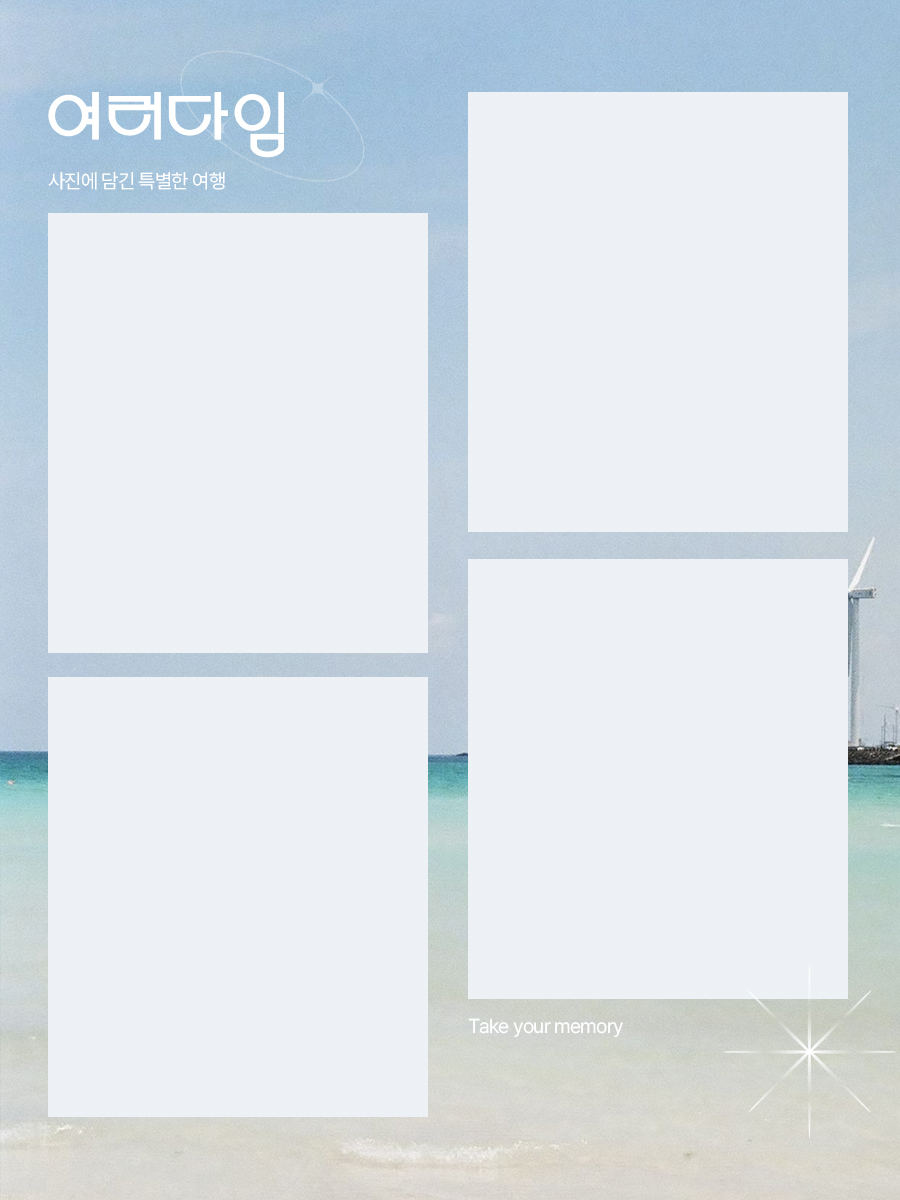

In [6]:
display(frame)

In [3]:
prefix_info = {
  'image' : "assets/photoDigm/userPicture/",
  'frame' : "assets/photoDigm/frame/",
  'photoDigm' : "assets/photoDigm/photoDigm/",
}

def connect_s3():
  with open("/content/drive/MyDrive/yeoreodigm/data_files/aws_access_info.json") as f:
    aws_access_info = json.load(f)
  return boto3.resource('s3',aws_access_key_id=aws_access_info['AWS_ACCESS_KEY_ID'],
                                  aws_secret_access_key=aws_access_info['AWS_SECRET_ACCESS_KEY'],
                                  region_name=aws_access_info['REGION_NAME'])

#s3는 boto3.resource 객체
def load_image(s3,img_type,file_name): 
  bucket = 'yeoreodigm-s3'
  prefix = prefix_info[img_type]
  entire_path = prefix + file_name
  Bucket = s3.Bucket(bucket)
  object_ = Bucket.Object(entire_path)
  response = object_.get()
  file_stream = response['Body']
  img = Image.open(file_stream)
  return img

In [23]:
s3 = connect_s3()
jimin = load_image(s3,'image','jimin.jepg')

In [ ]:
s3 = connect_s3()
jimin2_1 = load_image(s3,'image','jimin.png')

In [ ]:
jimin2_1_resize = jimin2_1.resize((380,440))
display(jimin2_1_resize)


In [28]:
frame.size

(900, 1200)

##정규표현식으로 프레임 번호 추출

In [29]:
import re

string = 'frame17.png'
numbers = re.sub(r'[^0-9]', '', string)
print(numbers)

17


##frame 메타데이터 추출

In [4]:
from PIL.ExifTags import TAGS

In [32]:
test_exif = load_image(s3,'frame','Frame1 info.jpg')

###exif 태그 종류

In [136]:
#print(TAGS)
for k,v in TAGS.items():
  print(k,v)

11 ProcessingSoftware
254 NewSubfileType
255 SubfileType
256 ImageWidth
257 ImageLength
258 BitsPerSample
259 Compression
262 PhotometricInterpretation
263 Thresholding
264 CellWidth
265 CellLength
266 FillOrder
269 DocumentName
270 ImageDescription
271 Make
272 Model
273 StripOffsets
274 Orientation
277 SamplesPerPixel
278 RowsPerStrip
279 StripByteCounts
280 MinSampleValue
281 MaxSampleValue
282 XResolution
283 YResolution
284 PlanarConfiguration
285 PageName
288 FreeOffsets
289 FreeByteCounts
290 GrayResponseUnit
291 GrayResponseCurve
292 T4Options
293 T6Options
296 ResolutionUnit
297 PageNumber
301 TransferFunction
305 Software
306 DateTime
315 Artist
316 HostComputer
317 Predictor
318 WhitePoint
319 PrimaryChromaticities
320 ColorMap
321 HalftoneHints
322 TileWidth
323 TileLength
324 TileOffsets
325 TileByteCounts
330 SubIFDs
332 InkSet
333 InkNames
334 NumberOfInks
336 DotRange
337 TargetPrinter
338 ExtraSamples
339 SampleFormat
340 SMinSampleValue
341 SMaxSampleValue
342 Transfe

In [39]:
exif_data = test_exif.getexif()

In [42]:
for id,value in exif_data.items():
  print(id, TAGS.get(id), value)

40961 ColorSpace 65535
40962 ExifImageWidth 1800
40963 ExifImageHeight 2400
296 ResolutionUnit 2
34665 ExifOffset 168
305 Software Adobe Photoshop 23.5 (Macintosh)
274 Orientation 1
306 DateTime 2022:10:17 11:41:37
282 XResolution (720000, 10000)
283 YResolution (720000, 10000)


In [51]:
exif_data[270] = 'frame21'

In [52]:
for id,value in exif_data.items():
  print(id, TAGS.get(id), value)

40961 ColorSpace 65535
40962 ExifImageWidth 1800
40963 ExifImageHeight 2400
296 ResolutionUnit 2
34665 ExifOffset 168
270 ImageDescription frame21
305 Software Adobe Photoshop 23.5 (Macintosh)
274 Orientation 1
306 DateTime 2022:10:17 11:41:37
282 XResolution (720000, 10000)
283 YResolution (720000, 10000)


###s3 upload & download 이후 메타데이터가 유지되는지 확인

In [10]:
def upload_image(s3,img, img_type,key):
  bucket = 'yeoreodigm-s3'
  Bucket = s3.Bucket(bucket)
  save_path = prefix_info[img_type] + key
  print('저장경로 : ',save_path)
  object_ = Bucket.Object(save_path)

  file_stream = io.BytesIO()
  
  img.save(file_stream,format='png') # binary data를 BytesIO로 변환해서 file stream에 담기
  object_.put(Body = file_stream.getvalue(),ContentType='image/png')
  print("image upload done!!")

In [60]:
for key, val in test_exif.getexif().items():
  print(key,val)

40961 65535
40962 1800
40963 2400
296 2
34665 168
270 frame21
305 Adobe Photoshop 23.5 (Macintosh)
274 1
306 2022:10:17 11:41:37
282 (720000, 10000)
283 (720000, 10000)


In [61]:
test_exif.info['exif'] = test_exif.getexif()

In [62]:
upload_image(s3,test_exif,'frame','frame17.png')

저장경로 :  assets/photoDigm/frame/frame17.png


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


image upload done!!


In [63]:
check_meta_data = load_image(s3,'frame','frame17.png')

In [64]:
check_exif = check_meta_data.getexif()

In [72]:
for key,val in check_exif.items():
  print(key,val)

40961 65535
40962 1800
40963 2400
296 2
34665 168
270 frame21
305 Adobe Photoshop 23.5 (Macintosh)
274 1
306 2022:10:17 11:41:37
282 (720000, 1)
283 (720000, 1)


In [ ]:
check_meta_data

In [173]:
frame18 = Image.open("/content/drive/MyDrive/pillow_image_files/design_template/Frame2 info.jpg")

In [175]:
frame18_exif = frame18.getexif()
for key, val in frame18_exif.items():
  print(type(key),type(val))
  print(key,val)

<class 'int'> <class 'int'>
40961 1
<class 'int'> <class 'int'>
40962 2400
<class 'int'> <class 'int'>
40963 1800
<class 'int'> <class 'int'>
296 2
<class 'int'> <class 'int'>
34665 168
<class 'int'> <class 'str'>
305 Adobe Photoshop 23.5 (Macintosh)
<class 'int'> <class 'int'>
274 1
<class 'int'> <class 'str'>
306 2022:10:17 15:51:21
<class 'int'> <class 'tuple'>
282 (720000, 10000)
<class 'int'> <class 'tuple'>
283 (720000, 10000)


In [176]:
frame18_exif[270] = 18
for key, val in frame18_exif.items():
  print(key,val)

40961 1
40962 2400
40963 1800
296 2
34665 168
270 18
305 Adobe Photoshop 23.5 (Macintosh)
274 1
306 2022:10:17 15:51:21
282 (720000, 10000)
283 (720000, 10000)


In [177]:
for k in frame18_exif.keys():
  if k!=0x0112 and k!=0x10E: # orientation information (0x0112),frame number (0x10E)
    print(k)
    frame18_exif[k] = None
    del frame18_exif[k]
print("*"*30)
for key, val in frame18_exif.items():
  print(key,val)

40961
40962
40963
296
34665
305
306
282
283
******************************
274 1
270 18


In [181]:
for key, val in frame18_exif.items():
  print(key,val)

274 1
270 18


In [182]:
frame18_exif[270] = '18'

In [183]:
frame18_exif.tobytes()

b'Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x02\x01\x0e\x00\x02\x00\x00\x00\x0318\x00\x00\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00'

In [184]:
new_exif = frame18_exif.tobytes()

In [185]:
frame18.info["exif"] = new_exif

In [188]:
for k,v in frame18.getexif().items():
  print(k,v)

274 1
270 18


##다시 업로드하고 확인

In [189]:
upload_image(s3,frame18,'frame','frame18.png')

저장경로 :  assets/photoDigm/frame/frame18.png
image upload done!!


In [190]:
check_frame18 = load_image(s3,'frame','frame18.png')

In [191]:
for key,val in check_frame18.getexif().items():
  print(key,val)

274 1
270 18


###기존에 업로드한 포토다임 exif 데이터 확인해보기


In [135]:
tmp = load_image(s3,'photoDigm','final_test6')
tmp_exif = tmp.getexif()
for key,val in tmp_exif.items():
  print(key,val)

274 1


##포토다임 프레임에 사진 하나씩 다 넣어보기

In [49]:
frame_coordinate = {1:((180,400),(930,190),(180,1364),(930,1154)),2:((80,155),(1068,155),(80,915),(1068,915)),3:((180,363),(930,150),(180,1327),(930,1114)),\
                      4:((90,160),(1095,160),(230,920),(1235,920)),5:((160,180),(920,180),(160,1200),(920,1200)),6:((90,160),(1095,160),(345,925),(1350,925)),\
                        7:((160,170),(920,170),(159,1190),(920,1200)),8:((34,110),(323,110),(33,473),(323,473))}

frame_inner_size = {1:(690,920),2:(960,720),3:(690,920),4:(960,720),5:(720,960),6:(960,720),7:(720,960),8: (260,340)}

In [40]:
frame_coordinate[3]

((180, 363), (930, 150), (180, 1354), (930, 1114))

In [42]:
def test(frame_img,frame_num,img1,img2,img3,img4):
  coordinate = frame_coordinate[frame_num]
  inner_size = frame_inner_size[frame_num]
  print("이미지 편집 전 exif 데이터")
  for k,v in frame_img.getexif().items():
    print(k,v)
  if img1:
    frame_img.paste(img1.resize(inner_size),coordinate[0])
  if img2:
    frame_img.paste(img2.resize(inner_size),coordinate[1])
  if img3:
    frame_img.paste(img3.resize(inner_size),coordinate[2])
  if img4:
    frame_img.paste(img4.resize(inner_size),coordinate[3])
  
  print("loaded image files and process done!!")
  print("이미지 편집 후 exif 데이터")
  for k,v in frame_img.getexif().items():
    print(k,v)
  return frame_img

In [50]:
img1 = Image.open("/content/drive/MyDrive/pillow_image_files/지민누나/jimin1.png")
img2 = Image.open("/content/drive/MyDrive/pillow_image_files/지민누나/jimin2.png")
img3 = Image.open("/content/drive/MyDrive/pillow_image_files/지민누나/jimin3.png")
img4 = Image.open("/content/drive/MyDrive/pillow_image_files/지민누나/jimin4.png")

In [51]:
frame = Image.open("/content/drive/MyDrive/pillow_image_files/design_template/Frame3 info.jpg")

In [52]:
result_img = test(frame,3,img1,img2,img1,img4)
result_img

Output hidden; open in https://colab.research.google.com to view.

In [262]:
for k,v in result_img.getexif().items():
  print(k,v)

40961 65535
40962 1800
40963 2400
296 2
34665 168
305 Adobe Photoshop 23.5 (Macintosh)
274 1
306 2022:10:17 16:13:27
282 (720000, 10000)
283 (720000, 10000)


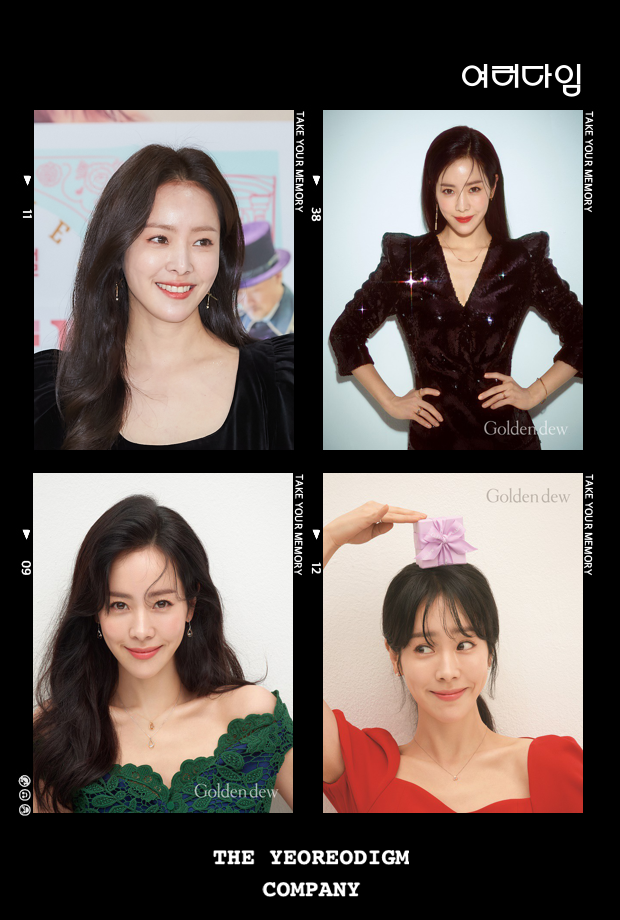

In [255]:
display(result_img)

##실제 프레임 exif data 추가 후 삽입 작업

In [7]:
s3 = connect_s3()

In [20]:
for i in range(1,9):
  dir_path = "/content/drive/MyDrive/pillow_image_files/design_template/"
  file_name = "frame"+str(i)+'.png'
  entire_path = dir_path + file_name
  print(entire_path)
  frame = Image.open(entire_path)
  frame_exif = frame.getexif()
  frame_exif[270] = str(i)
  for k in frame_exif.keys():
    if k!=0x0112 and k!=0x10E: # orientation information (0x0112),frame number (0x10E)
      print(k)
      frame_exif[k] = None
      del frame_exif[k]
  print("*"*30)
  for key, val in frame_exif.items():
    print(key,val)

  new_exif = frame_exif.tobytes()
  frame.info['exif'] = new_exif
  upload_image(s3,frame,'frame',file_name)



/content/drive/MyDrive/pillow_image_files/design_template/frame1.png
40962
40963
36868
282
283
296
34665
305
306
******************************
274 1
270 1
저장경로 :  assets/photoDigm/frame/frame1.png
image upload done!!
/content/drive/MyDrive/pillow_image_files/design_template/frame2.png
40961
40962
40963
36868
282
283
296
34665
305
306
******************************
274 1
270 2
저장경로 :  assets/photoDigm/frame/frame2.png
image upload done!!
/content/drive/MyDrive/pillow_image_files/design_template/frame3.png
40962
40963
36868
282
283
296
34665
305
306
******************************
274 1
270 3
저장경로 :  assets/photoDigm/frame/frame3.png
image upload done!!
/content/drive/MyDrive/pillow_image_files/design_template/frame4.png
40961
40962
40963
36868
282
283
296
34665
305
306
******************************
274 1
270 4
저장경로 :  assets/photoDigm/frame/frame4.png
image upload done!!
/content/drive/MyDrive/pillow_image_files/design_template/frame5.png
40962
40963
36868
282
283
296
34665
305
306
***

In [25]:
for i in range(1,9):
  test_exif = load_image(s3,'frame','frame'+ str(i) + '.png')
  exif_data = test_exif.getexif()
  print("frame %d"%i,"*"*30)
  for key,val in exif_data.items():
    print(key,val)
  print(test_exif.getexif()[270])
  test_exif.save("/content/drive/MyDrive/pillow_image_files/design_template/"+"downloaded_frame" + str(i) + ".png")

load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 1 ******************************
274 1
270 1
1
load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 2 ******************************
274 1
270 2
2
load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 3 ******************************
274 1
270 3
3
load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 4 ******************************
274 1
270 4
4
load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 5 ******************************
274 1
270 5
5
load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 6 ******************************
274 1
270 6
6
load_image....
S

##frame 정보 db에 반영하기

In [53]:
import psycopg2

In [54]:
def load_db():
  with open("/content/drive/MyDrive/yeoreodigm/data_files/db_info.json") as json_file:
    DB_INFO = json.load(json_file)
  
  endpoint = DB_INFO["ENDPOINT"]
  dbname = DB_INFO["DB_NAME"]
  user = DB_INFO["USER_ID"]
  password = DB_INFO["PASSWORD"]
  db = psycopg2.connect(host=endpoint,dbname=dbname,user=user,password=password)
  return db

In [55]:
db=load_db()
cursor=db.cursor()

In [ ]:
frame_size = [(1800,2400),(2400,1800)] #홀수넘버 사이즈 / 짝수넘버 사이즈

In [59]:
db.rollback()

In [60]:
for i in range(1,8):
  title = str(i)+'번프레임'
  address = 'frame'+str(i)+'.png'
  size_ = frame_size[(i+1)%2]
  size_x = size_[0]
  size_y = size_[1]
  print(title,address,size_x,size_y)
  cursor.execute("insert into frame(title,address,x_size,y_size) values(%s,%s,%s,%s)",(title,address,size_x,size_y))
db.commit()

1번프레임 frame1.png 1800 2400
2번프레임 frame2.png 2400 1800
3번프레임 frame3.png 1800 2400
4번프레임 frame4.png 2400 1800
5번프레임 frame5.png 1800 2400
6번프레임 frame6.png 2400 1800
7번프레임 frame7.png 1800 2400


###9번프레임에 exif 데이터 추가

In [61]:
i=9
test_exif = load_image(s3,'frame','frame'+ str(i) + '.png')
exif_data = test_exif.getexif()
print("frame %d"%i,"*"*30)
for key,val in exif_data.items():
  print(key,val)
exif_data[270] = "9"
test_exif.info['exif'] = exif_data.tobytes()
print(test_exif.getexif()[270])
test_exif.save("/content/drive/MyDrive/pillow_image_files/design_template/"+"downloaded_frame" + str(i) + ".png")
upload_image(s3,test_exif,'frame','frame9.png')

load_image....
Successfully loaded original img
applying new process if img has rotation info
Everything done.
frame 9 ******************************
9
저장경로 :  assets/photoDigm/frame/frame9.png
image upload done!!


###7번프레임 안에 문구 제거하기

In [68]:
frame7 = Image.open("/content/drive/MyDrive/pillow_image_files/design_template/frame7.png")
exif_data = frame7.getexif()
exif_data[270] = '7'
i = 7

print("*"*30,"frame %d"%i,"*"*30)
exif = frame7.getexif()
for k in exif.keys():
  if k!=0x0112 and k!= 0x10E: # orientation information (0x0112),frame number (0x10E)
    exif[k] = None
    del exif[k]
new_exif = exif.tobytes()
frame7.info["exif"] = new_exif



frame7.save("/content/drive/MyDrive/pillow_image_files/design_template/"+"downloaded_frame" + str(i) + ".png")
upload_image(s3,frame7,'frame','frame7.png')

****************************** frame 7 ******************************
저장경로 :  assets/photoDigm/frame/frame7.png
image upload done!!


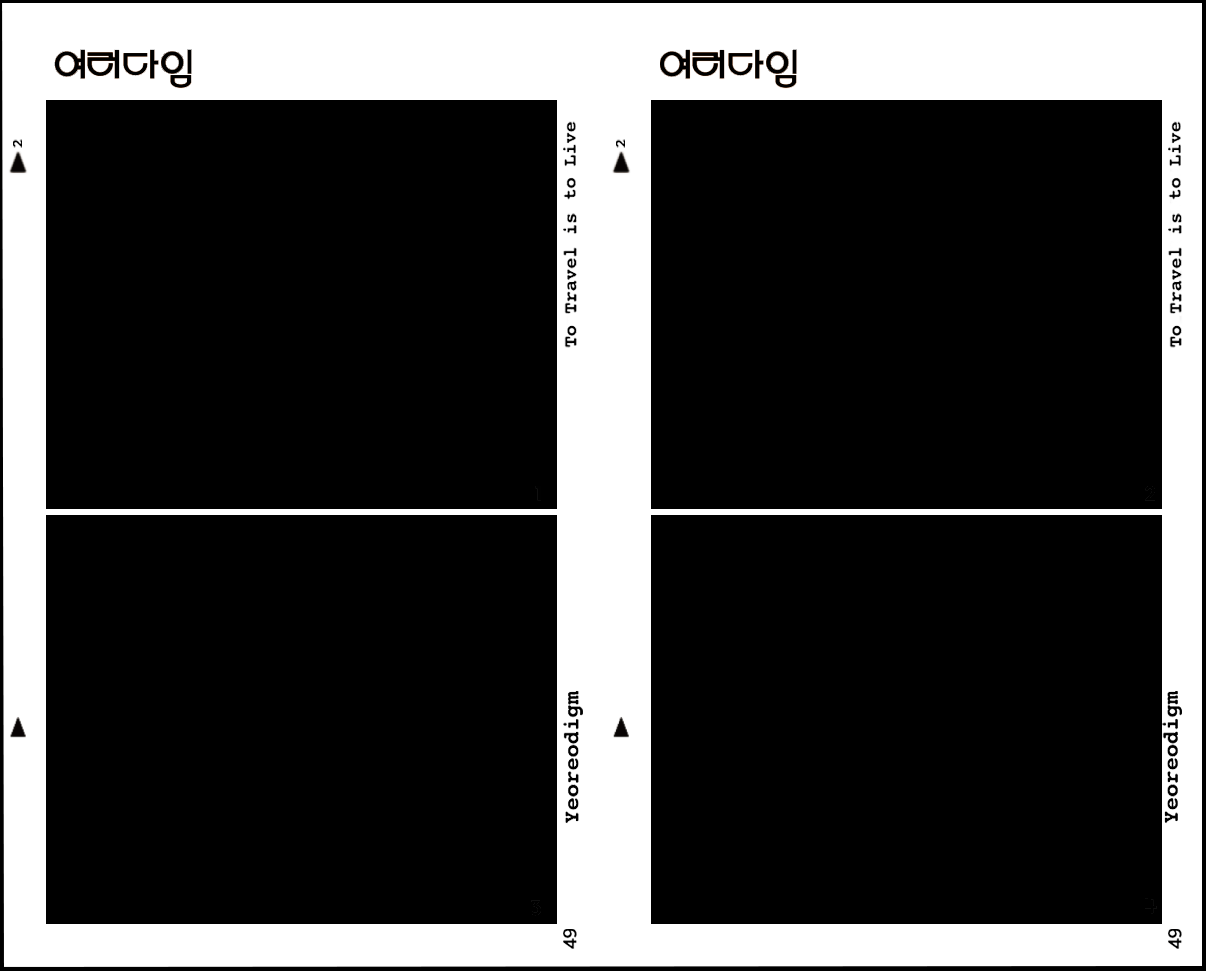

In [65]:
test_exif

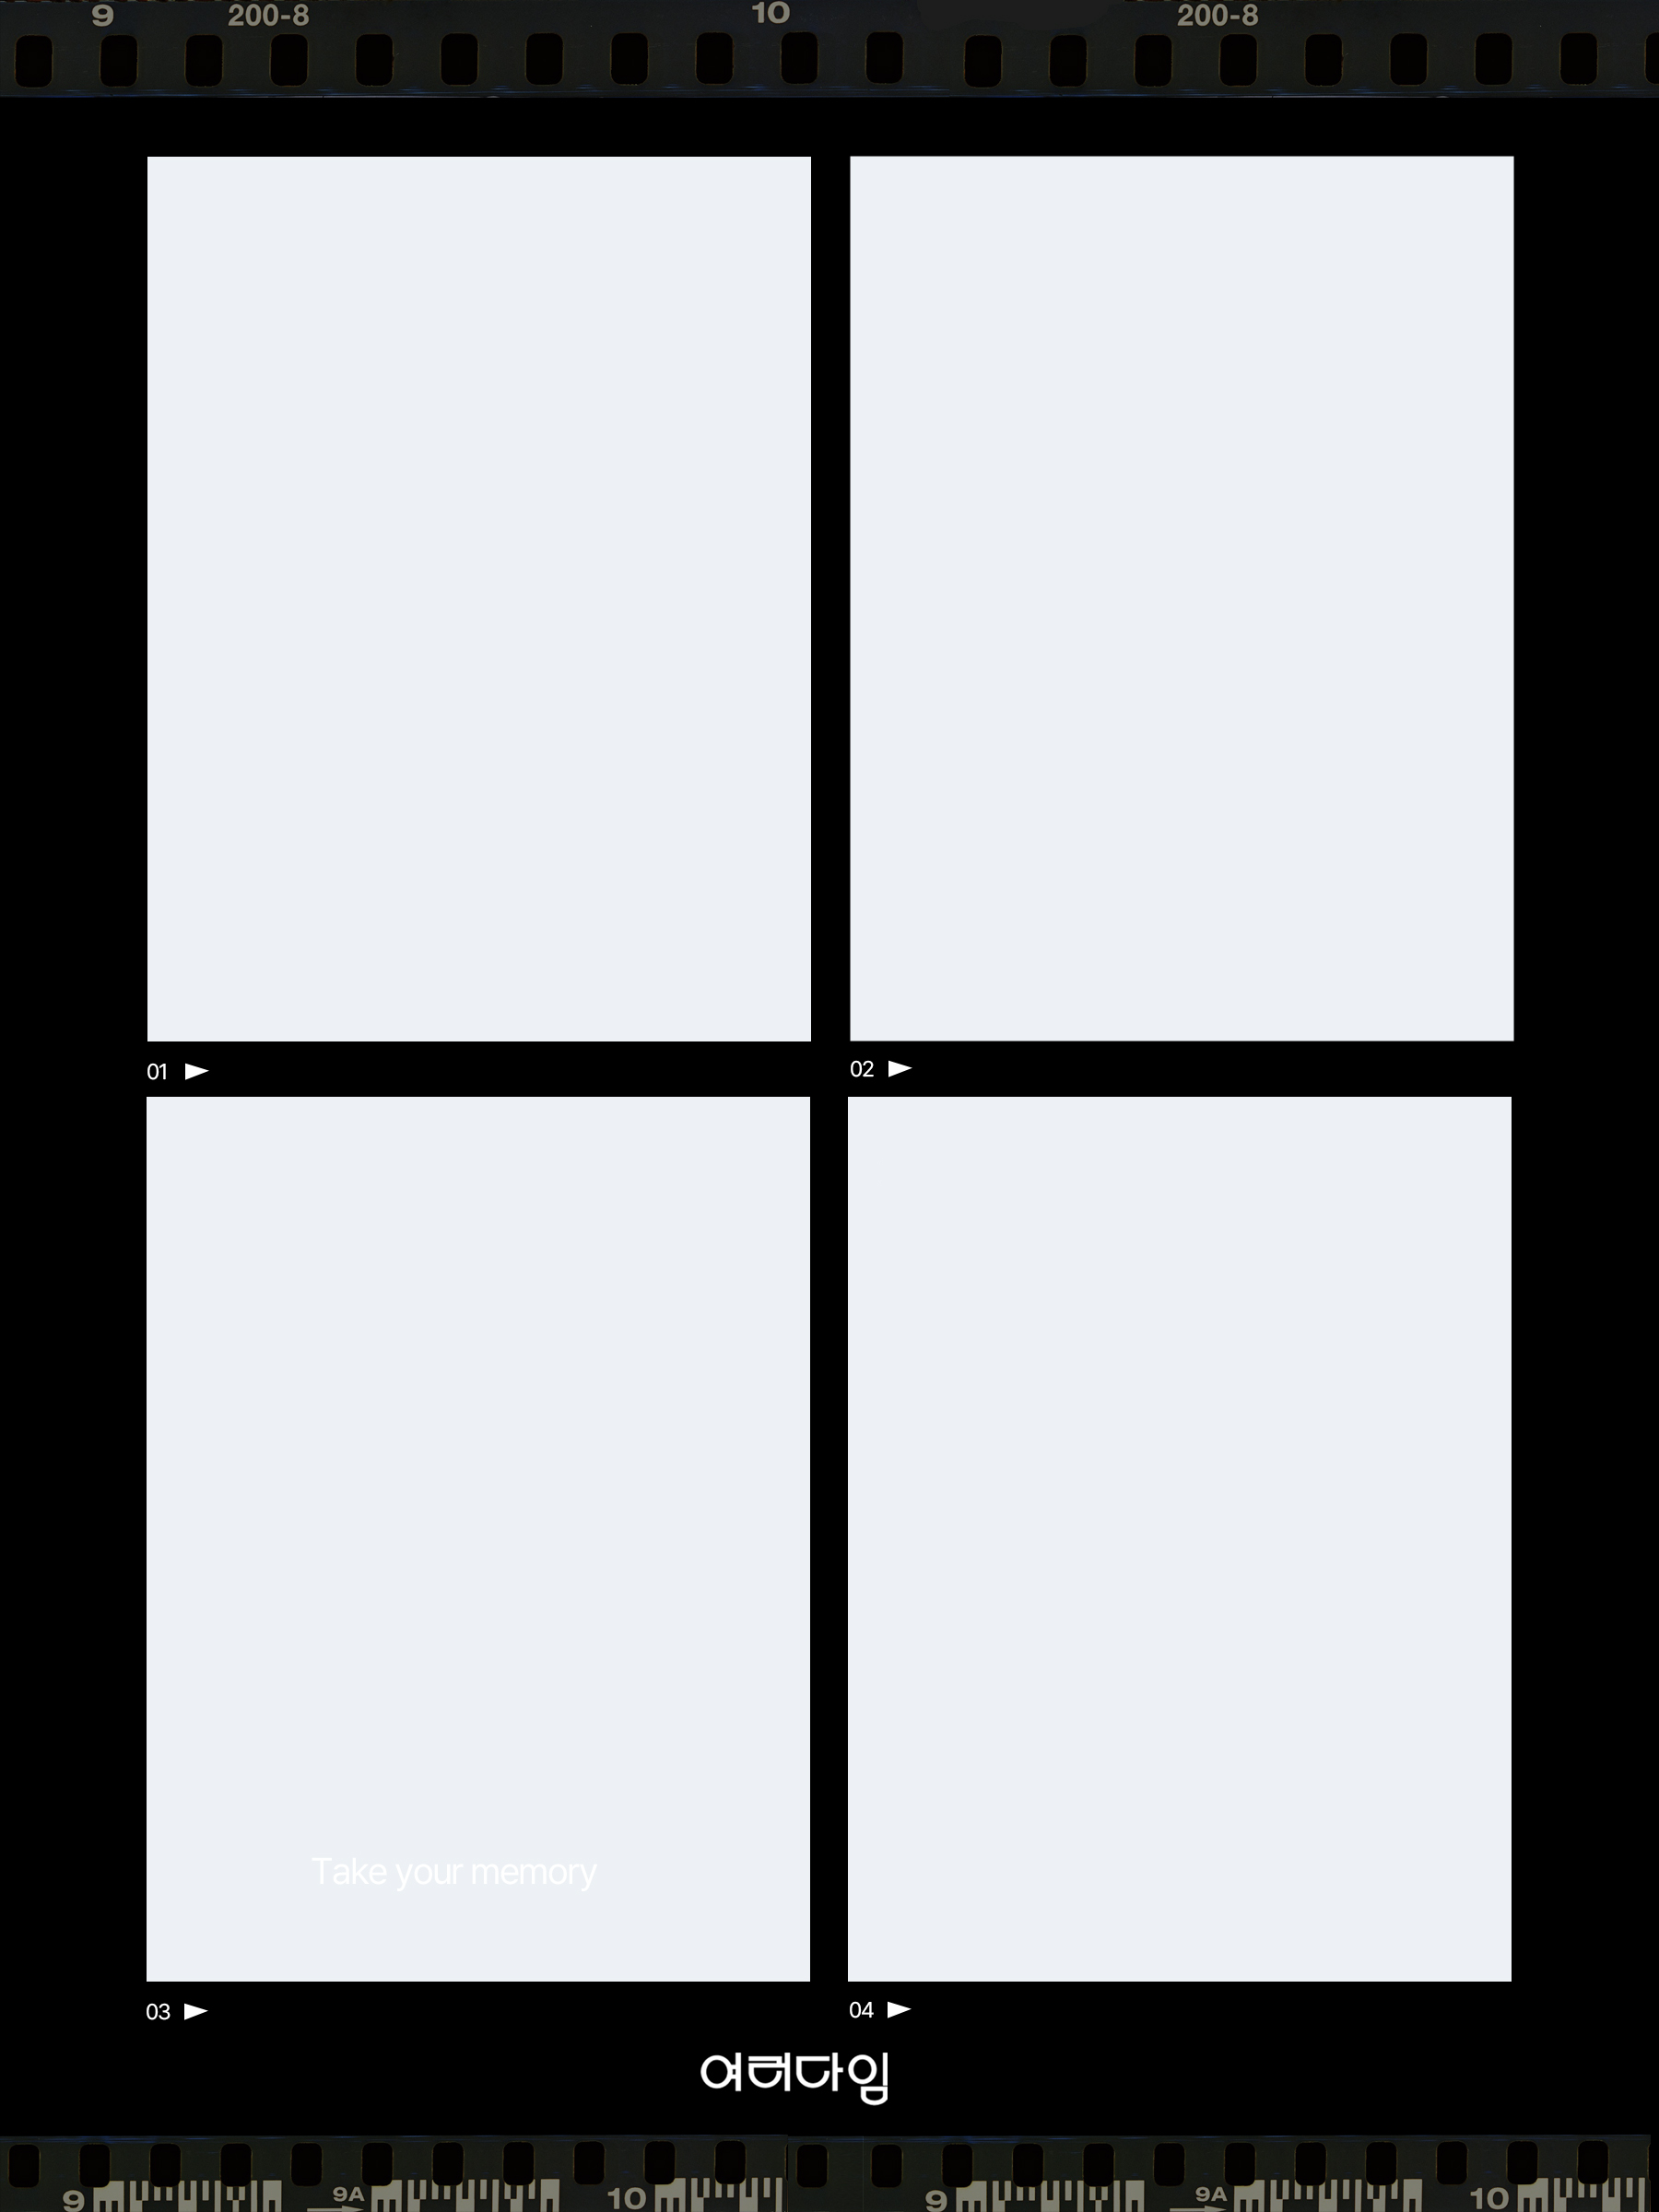

In [63]:
frame7